In [43]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import vgg16
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# seed
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [44]:
# model
model = vgg16(pretrained=True)
model = nn.DataParallel(model)
model.to(device)

# data
img_paths = glob.glob("./data/Zeiler-Fergus/*")

In [45]:
img_paths[0]

'./data/Zeiler-Fergus/gorilla.jpg'

In [46]:
'''課題3.3
BPによるCNNの可視化
'''

img_idx = 4
o_img = read_image(img_paths[img_idx])

In [47]:
# exp
transform_1 = v2.Compose([
    v2.Resize([256, 256]),
    v2.ToDtype(torch.float, scale=True),
])
transform_2 = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_1 = transform_1(o_img)
img_2 = transform_2(img_1).unsqueeze(0)
print(img_2.shape)

img_2.requires_grad_()

for param in model.parameters():
    param.requires_grad = False

model.eval()
output = model(img_2.to(device))
target_class = output.argmax(dim=1)
score = output[0, target_class]

model.zero_grad()
score.backward()

torch.Size([1, 3, 256, 256])


In [48]:
saliency = img_2.grad.abs().squeeze().permute(1,2,0).cpu().numpy()
saliency = np.max(saliency, axis=2)

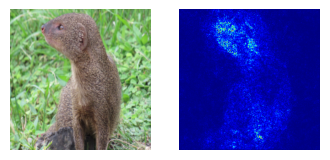

In [49]:
# 正規化してプロット
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(saliency, cmap='jet', vmin=0, vmax=1)